In [4]:
from glob import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from pyeit.mesh.wrapper import PyEITAnomaly_Circle
from src.vae3D import vae_model
from src.classes import Boundary, TankProperties32x2, BallAnomaly
from src.util import (
    seq_data, 
    load_exp_data,
    voxel_ball, 
    plot_voxel_c,
    load_3Ddata
)
from keras import backend as K
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Model

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from sklearn.decomposition import PCA

2025-03-18 13:19:48.973591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742303989.467156 4131664 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742303989.526373 4131664 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 13:19:50.101069: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1742304010.231054 4131664 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libr

## Load Data

In [35]:
voltage, gamma, _, temp, time = load_3Ddata("exp_data_set_3D_1", "exp_data_3D8", use_mean = True)
# exp_data_set_3D/exp_data_3D18
#exp_data_set_3D_1/exp_data_3D8 - Trichter_Helix

Loading experimental data...
Calculating mean of voltage differences...
Transforming position data...
Creating gamma...
Processing sequences with mean...
Data loading complete!


In [36]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os

def plot_temperature_vs_time(time, temp, vertical_line_idx=None,
                            title=None, xlabel="Zeit", ylabel="Temperatur (°C)", 
                            filename=None, fontsize=15):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(time, temp, linestyle='-', color='steelblue', linewidth=1)
  
    n = len(time)
    tick_indices = [
        0,                  
        n // 4,            
        n // 2,            
        3 * n // 4,        
        n - 1              
    ]
    
    dt = datetime.strptime(time[0], "%Y-%m-%d %H:%M:%S")
    date_str = dt.strftime("%d.%m.%Y")
   
    def format_time_with_index(ts, idx):
        dt = datetime.strptime(ts, "%Y-%m-%d %H:%M:%S")
        time_str = dt.strftime("%H:%M")
        return f"{time_str}\n({idx})"
    
    ax.set_xticks([time[i] for i in tick_indices])
    ax.set_xticklabels([format_time_with_index(time[i], i) for i in tick_indices])
    
    # Set font sizes
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    
    # Set tick label font sizes
    ax.tick_params(axis='both', which='major', labelsize=fontsize-2)
    
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    save_dir = "Abbildung_Temp"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    if filename:
        save_path = os.path.join(save_dir, f"{filename}.pdf")
        plt.savefig(save_path, format='pdf')
        print(f"Plot saved to {save_path}")
    
    return fig, ax

Plot saved to Abbildung_Temp/Temperatur_Analyse_Helix_small.pdf


(<Figure size 1000x600 with 1 Axes>,
 <Axes: xlabel='Zeit', ylabel='Temperatur (°C)'>)

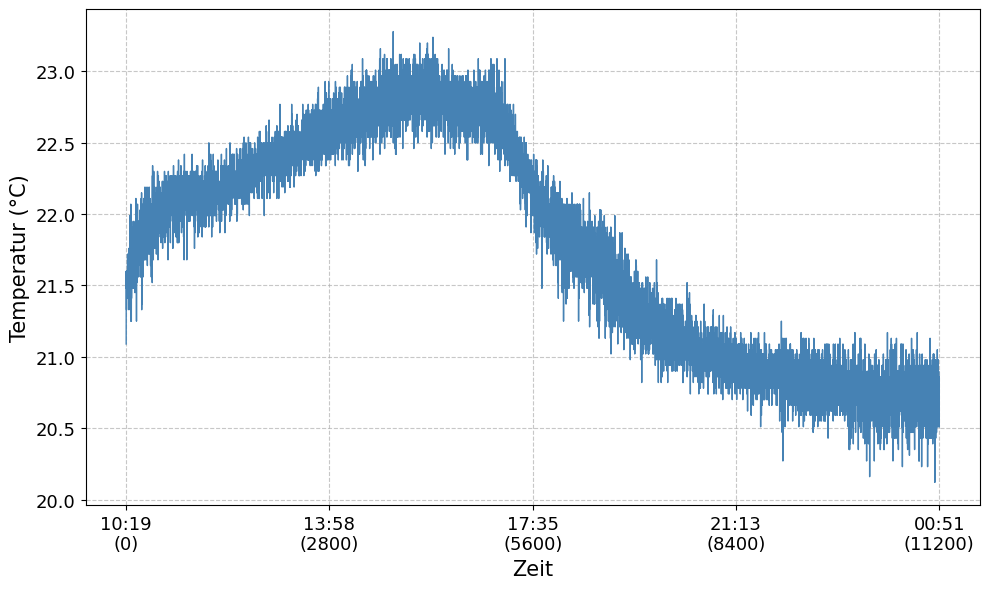

In [37]:
plot_temperature_vs_time(time, temp, vertical_line_idx=500, 
                         filename="Temperatur_Analyse_Helix_small")

In [6]:
print(f'Shape of Voltage Data:{voltage.shape}')
print(f'Shape of Conductivity Data:{gamma.shape}')

Shape of Voltage Data:(55980, 4, 64, 64)
Shape of Conductivity Data:(55980, 32, 32, 32)


## Loading VAE Model and generating labels

In [7]:
beta =  1.04
vae = vae_model(input_shape=(32, 32, 32, 1), filters=[1, 4, 8, 16], beta=beta)
vae.build(input_shape=(32, 32, 32, 1))
vae.load_weights("weights/3Dvae_best.weights.h5")
print("Gewichte erfolgreich geladen.")

Gewichte erfolgreich geladen.


In [8]:
_, _, latent_rep = vae.encoder.predict(gamma)

2025-03-08 11:37:23.165493: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 7337410560 exceeds 10% of free system memory.


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 62s 35ms/step


## LSTM Mapper Training

In [9]:
(
    v_train_seq,
    v_test_seq,
    g_train,
    g_test,
    z_train,
    z_test,
) = train_test_split(
    voltage,
    gamma,
    latent_rep,
    test_size=0.1,
    shuffle=True,
    random_state=42,
)

In [10]:
print(v_train_seq.shape)

(50382, 4, 64, 64)


In [11]:
from src.mapper3D import no_lstm_mapper3D_model
lstm_mapper = no_lstm_mapper3D_model()
lstm_mapper.summary()
lstm_mapper.compile(optimizer="adam", loss="mse")

Model: "dense_mapper"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 4, 64, 64, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 4, 31, 31, 2)   │            20 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 4, 15, 15, 2)   │            38 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 4, 450)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 4, 64)          │        28,864 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,810 (147.70 KB)

 Trainable params: 37,810 (147.70 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history_mapper = lstm_mapper.fit(v_train_seq, z_train, epochs=100, batch_size = 8, validation_split = 0.1)

Epoch 1/100
5668/5668 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 0.0499 - val_loss: 0.0085
Epoch 2/100
5668/5668 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.0065 - val_loss: 0.0039
Epoch 3/100
5668/5668 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 4/100
5668/5668 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 5/100
5668/5668 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 6/100
5668/5668 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 7/100
5668/5668 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 8/100
5668/5668 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 9/100
5668/5668 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 10/100
5668/5668 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 11/100
5668/5668 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 12

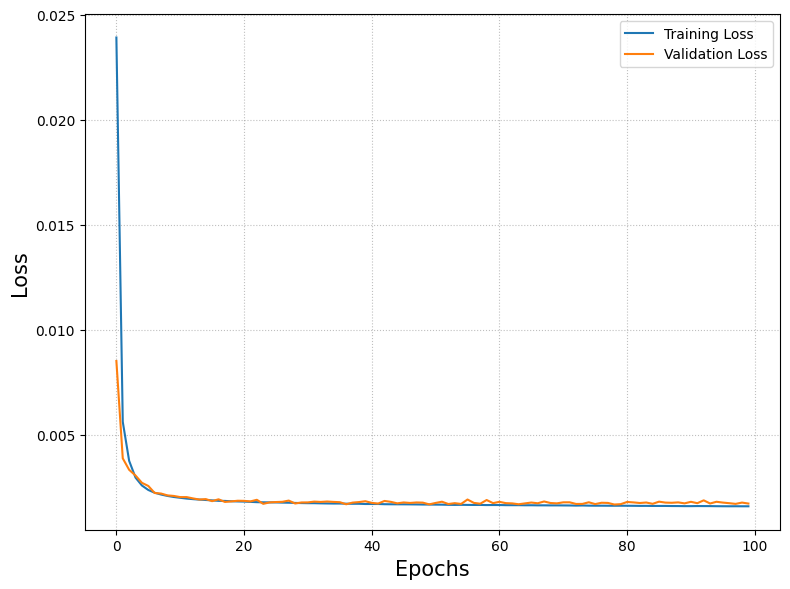

In [15]:
fpath = 'Abbildungen/'  
fname = 'loss_curve_3D_no_LSTM_11200_Trichter_Helix_1'

plt.figure(figsize=(8, 6))
plt.plot(history_mapper.history["loss"], label="Training Loss")
plt.plot(history_mapper.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle=':', color='gray', alpha=0.5)

plt.savefig(f'{fpath}{fname}.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [16]:
weights_dir = "weights/"
os.makedirs(weights_dir, exist_ok=True)
lstm_weights_file = os.path.join(weights_dir, "3D_no_lstm_11200_Trichter_Helix_1.weights.h5")
lstm_mapper.save_weights(lstm_weights_file)
print(f"Gewichte gespeichert unter: {lstm_weights_file}")

Gewichte gespeichert unter: weights/3D_no_lstm_11200_Trichter_Helix_1.weights.h5


In [ ]:
#das der latente Raum die Information entlang der z-Achse besser in den latenten Raum abbilden kann, als bei der x-y-Achse.

# Aufgrund der größeren Kugelgröße und der Position der Trajektorie einen Einfluss auf die Rekonstruktionsqualität, was beim 2D Dim

# Spannungsdaten aufbereitung anpassen, um die Performance von Encocer zu steigern, indem irrelavente Informationen eliminiert werden und nützlihce Informationen gepusht werden (Ideen?)

# Motion amplification (Bildverarbeitungstechniken, pixel)